In [2]:
import pandas as pd

In [62]:
df = pd.read_csv('sapmaintance.csv', encoding='ISO-8859-1', sep=";")

df.columns = df.columns.str.strip()

df = df[df["Rodzaj zawiad."] == "1P"]

df.dropna(subset=["Opis", "Nr zlec.", "Oznaczenie"], inplace=True)

df["Priorytet"] = df["Priorytet"].fillna("Brak")

df["Data zawiadom."] = pd.to_datetime(df["Data zawiadom."], errors="coerce")
df["Nr zlec."] = df["Nr zlec."].astype("Int64")

df = df[df["Data zawiadom."] >= "2020-01-01"]

df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)

df["Dzien_tygodnia"] = df["Data zawiadom."].dt.day_name()

df.sort_values(by=["Oznaczenie", "Data zawiadom."], inplace=True)
df["Dni_od_ostatniej_awarii"] = df.groupby("Oznaczenie")["Data zawiadom."].diff().dt.days
df_gaps = df[df["Dni_od_ostatniej_awarii"].notna()]
result = df_gaps[["Oznaczenie", "Data zawiadom.", "Dni_od_ostatniej_awarii"]]
result = result.sort_values(by=["Oznaczenie", "Data zawiadom."])

filtered = df[["Oznaczenie", "Dni_od_ostatniej_awarii"]].dropna()
mean_gaps = (
    filtered.groupby("Oznaczenie")["Dni_od_ostatniej_awarii"]
    .mean()
    .sort_values(ascending=True)
)

print(mean_gaps[mean_gaps.index.str.contains("pakowaczka", case=False)])

Oznaczenie
1-Pakowaczka 1                         4.685637
1-Pakowaczka 2                         5.301115
1-Pakowaczka 5                         5.970833
1-Pakowaczka 4                         6.134921
1-Pakowaczka 3                         6.285185
1-Pakowaczka 7                         7.668122
1-Pakowaczka 6                         7.780374
1-Pakowaczka 8                         9.196429
1-Pakowaczka zbiorcza 2               14.174419
1-Pakowaczka 11                       14.303371
1-Pakowaczka MINI 2                   16.559524
1-Pakowaczka 9                        18.868421
1-Pakowaczka zbiorcza 4               21.890625
1-Pakowaczka MINI 1                   23.814286
1-Pakowaczka zbiorcza 5               23.964912
1-Pakowaczka 10                       25.105263
1-Pakowaczka MINI 3                   25.482143
1-Pakowaczka zbiorcza 3. MASPE        30.400000
1-Pakowaczka zbiorcza 1               31.743590
1-Pakowaczka T3 1                     31.904762
1-Pakowaczka zbiorcza 7      

In [63]:
print(result[result["Oznaczenie"].str.contains("pakowaczka", case=False, na=False)].sort_values(by="Data zawiadom.", ascending=False).head(20))

                   Oznaczenie Data zawiadom.  Dni_od_ostatniej_awarii
181            1-Pakowaczka 9     2025-12-06                      3.0
174            1-Pakowaczka 2     2025-12-06                      1.0
201            1-Pakowaczka 4     2025-12-06                      2.0
910            1-Pakowaczka 5     2025-12-05                      0.0
945            1-Pakowaczka 1     2025-12-05                      0.0
929            1-Pakowaczka 5     2025-12-05                      0.0
902            1-Pakowaczka 5     2025-12-05                      2.0
917            1-Pakowaczka 1     2025-12-05                      1.0
925   1-Pakowaczka zbiorcza 4     2025-12-05                      2.0
950            1-Pakowaczka 8     2025-12-05                     29.0
924            1-Pakowaczka 2     2025-12-05                      3.0
965            1-Pakowaczka 2     2025-12-05                      0.0
940       1-Pakowaczka MINI 3     2025-12-05                     60.0
1598           1-Pak

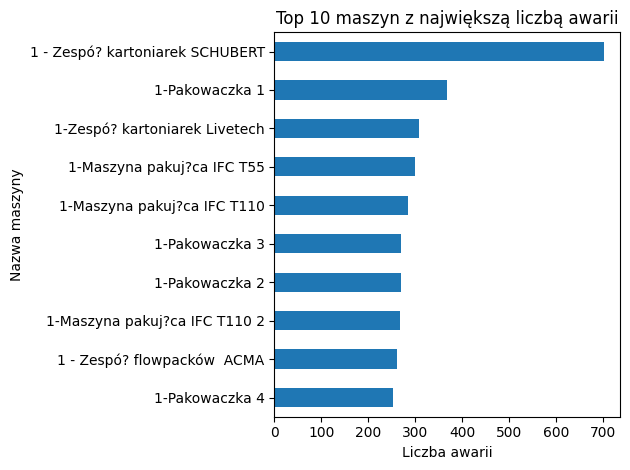

In [76]:
import matplotlib.pyplot as plt

top_machines = df["Oznaczenie"].value_counts().head(10)

top_machines.plot(kind="barh", title="Top 10 maszyn z największą liczbą awarii")
plt.xlabel("Liczba awarii")
plt.ylabel("Nazwa maszyny")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

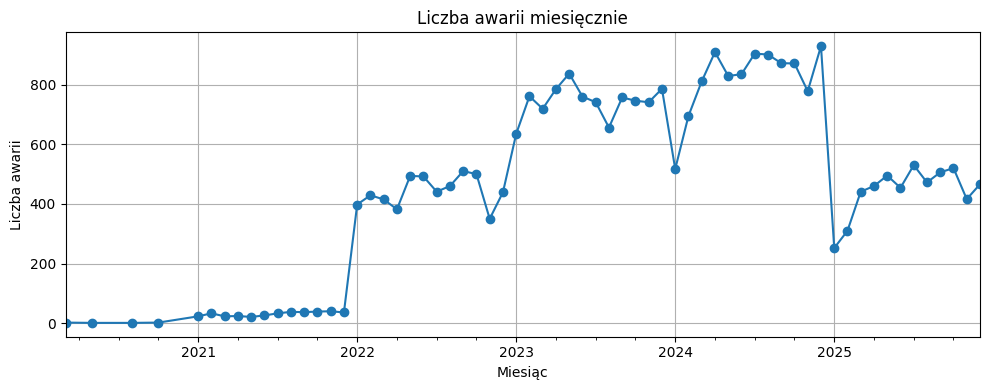

In [66]:
df["Miesiąc"] = df["Data zawiadom."].dt.to_period("M")
failures_per_month = df["Miesiac"].value_counts().sort_index()

failures_per_month.plot(kind="line", marker='o', title="Liczba awarii miesięcznie", figsize=(10, 4))
plt.xlabel("Miesiąc")
plt.ylabel("Liczba awarii")
plt.grid(True)
plt.tight_layout()
plt.show()

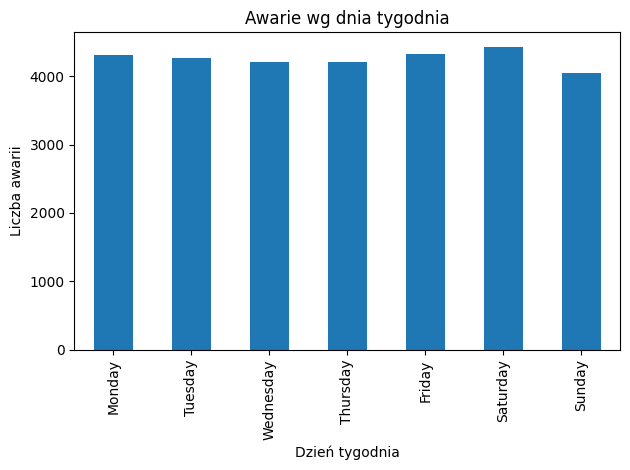

In [67]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
failures_by_day = df["Dzien_tygodnia"].value_counts().reindex(days)

failures_by_day.plot(kind="bar", title="Awarie wg dnia tygodnia")
plt.ylabel("Liczba awarii")
plt.xlabel("Dzień tygodnia")
plt.tight_layout()
plt.show()

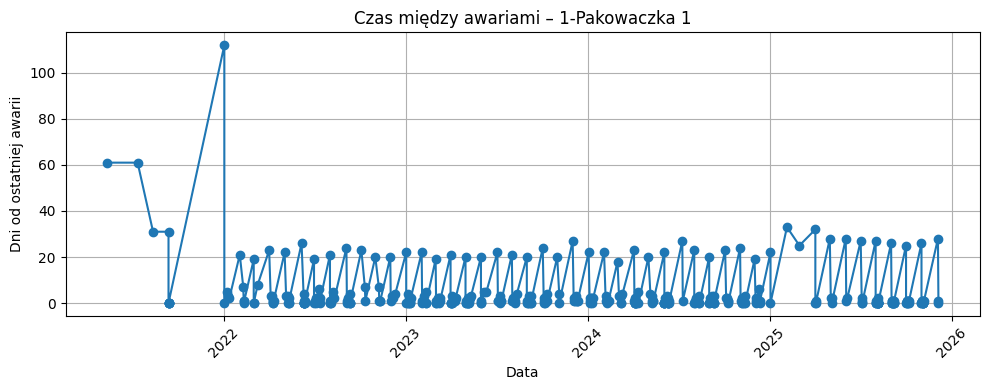

In [18]:
machine_data = result[result["Oznaczenie"] == "1-Pakowaczka 1"]

plt.figure(figsize=(10, 4))
plt.plot(machine_data["Data zawiadom."], machine_data["Dni_od_ostatniej_awarii"], marker='o')
plt.title("Czas między awariami – 1-Pakowaczka 1")
plt.xlabel("Data")
plt.ylabel("Dni od ostatniej awarii")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

df = df[df["Dni_od_ostatniej_awarii"].notna()] 
df["Target_szybko_awaria"] = (df["Dni_od_ostatniej_awarii"] < 30).astype(int)

df["Poprzedni_odstep"] = df.groupby("Oznaczenie")["Dni_od_ostatniej_awarii"].shift(1)

df["Typ_maszyny"] = df["Oznaczenie"].str.extract(r"(Pakowaczka|Kartoniarka|Modelator|Obracacz|Zgrzewarka)", expand=False)
df["Typ_maszyny"] = df["Typ_maszyny"].fillna("Inne")

X = df[["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Poprzedni_odstep"]].dropna()
X = pd.get_dummies(X)
y = df.loc[X.index, "Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.29      0.37      1602
           1       0.74      0.89      0.81      3709

    accuracy                           0.71      5311
   macro avg       0.64      0.59      0.59      5311
weighted avg       0.68      0.71      0.68      5311

Confusion Matrix:
[[ 460 1142]
 [ 397 3312]]


In [71]:
sample = pd.DataFrame({
    "Oznaczenie": ["1-Pakowaczka 1"],
    "Dzien_tygodnia": ["Monday"],
    "Priorytet": ["Wysoki"]
})

sample_encoded = pd.get_dummies(sample)

sample_encoded = sample_encoded.reindex(columns=X.columns, fill_value=0)

prediction = model.predict(sample_encoded)
probability = model.predict_proba(sample_encoded)

print("Czy szybka awaria?:", "Tak" if prediction[0] == 1 else "Nie")
print("Prawdopodobieństwo szybkiej awarii:", round(probability[0][1] * 100, 2), "%")


Czy szybka awaria?: Tak
Prawdopodobieństwo szybkiej awarii: 65.43 %


In [72]:
sample2 = pd.DataFrame({
    "Oznaczenie": ["1-Nalewarka 1"],
    "Dzien_tygodnia": ["Friday"],
    "Priorytet": ["Brak"]
})

sample2_encoded = pd.get_dummies(sample2)
sample2_encoded = sample2_encoded.reindex(columns=X.columns, fill_value=0)

prediction2 = model.predict(sample2_encoded)
probability2 = model.predict_proba(sample2_encoded)

print("Czy szybka awaria?:", "Tak" if prediction2[0] == 1 else "Nie")
print("Prawdopodobieństwo szybkiej awarii:", round(probability2[0][1] * 100, 2), "%")


Czy szybka awaria?: Tak
Prawdopodobieństwo szybkiej awarii: 64.11 %


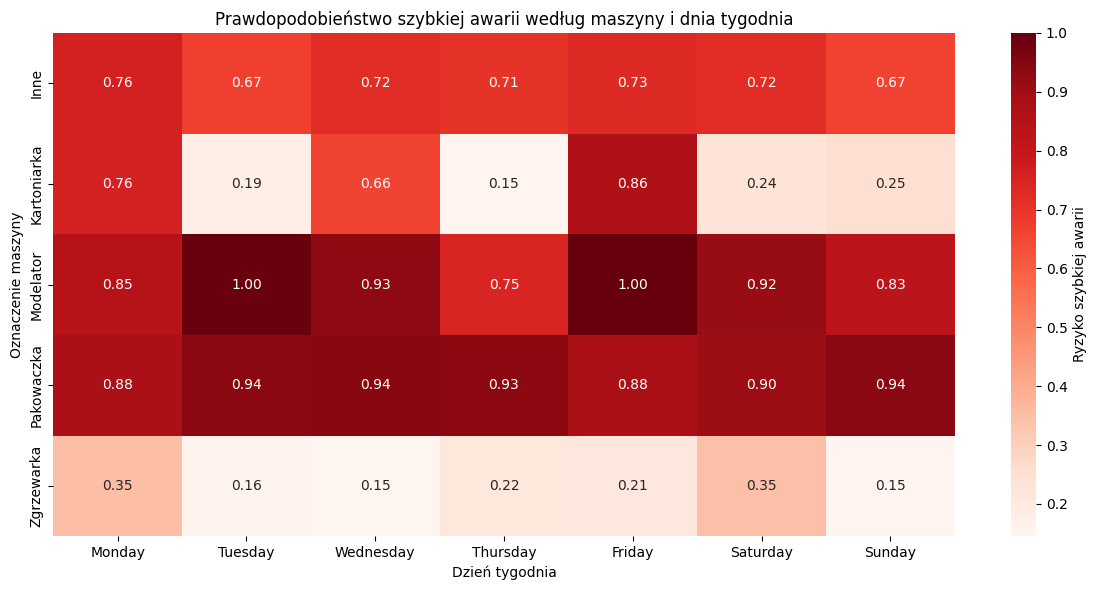

In [73]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

machines_with_types = df[df["Oznaczenie"].str.contains("Pakowaczka|Kartoniarka|Modelator|Obracacz|Zgrzewarka", case=False, na=False)]
top_machines = machines_with_types["Oznaczenie"].unique().tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"

combinations = list(itertools.product(top_machines, days))
test_df = pd.DataFrame(combinations, columns=["Oznaczenie", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Typ_maszyny"] = test_df["Oznaczenie"].str.extract(r"(Pakowaczka|Kartoniarka|Modelator|Maszyna pakuj[ąa]ca|Zgrzewarka)", expand=False)
test_df["Typ_maszyny"] = test_df["Typ_maszyny"].fillna("Inne")

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

test_df["Prawdopodobieństwo_szybkiej_awarii"] = model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot_table(
    index="Typ_maszyny",
    columns="Dzien_tygodnia",
    values="Prawdopodobieństwo_szybkiej_awarii",
    aggfunc="mean"
)

pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title("Prawdopodobieństwo szybkiej awarii według maszyny i dnia tygodnia")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Oznaczenie maszyny")
plt.tight_layout()
plt.show()

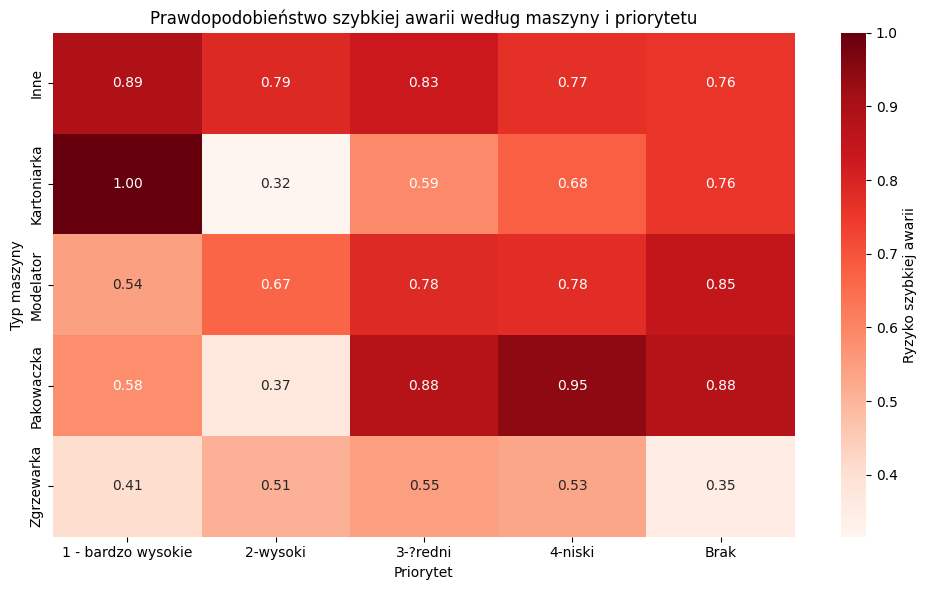

In [74]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

machines_with_types = df[df["Oznaczenie"].str.contains("Pakowaczka|Kartoniarka|Modelator|Obracacz|Zgrzewarka", case=False, na=False)]
top_machines = machines_with_types["Oznaczenie"].unique().tolist()
priorities = df["Priorytet"].unique().tolist()

combinations = list(itertools.product(top_machines, priorities))
test_df = pd.DataFrame(combinations, columns=["Oznaczenie", "Priorytet"])

test_df["Dzien_tygodnia"] = "Monday"

test_df["Typ_maszyny"] = test_df["Oznaczenie"].str.extract(r"(Pakowaczka|Kartoniarka|Modelator|Maszyna pakuj[ąa]ca|Zgrzewarka)", expand=False)
test_df["Typ_maszyny"] = test_df["Typ_maszyny"].fillna("Inne")

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

test_df["Prawdopodobieństwo_szybkiej_awarii"] = model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot_table(
    index="Typ_maszyny",
    columns="Priorytet",
    values="Prawdopodobieństwo_szybkiej_awarii",
    aggfunc="mean"
)

pivot = pivot[sorted(pivot.columns)]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title("Prawdopodobieństwo szybkiej awarii według maszyny i priorytetu")
plt.xlabel("Priorytet")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()


In [75]:
df

,Rodzaj zawiad.,Zawiadomienie,Nr zlec.,Opis,Data zawiadom.,Oznaczenie,Utworzone przez,Priorytet,Status systemu,Dzien_tygodnia,Dni_od_ostatniej_awarii,Miesiac,Miesiąc,Target_szybko_awaria,Poprzedni_odstep,Typ_maszyny
3888,1P,12523756,50000213052,Uszkodzony motylek na myjce,2025-06-02,1 - Kabina do mycia,ORZECMACI1,3-?redni,MOBI PRZL ZWZK,Monday,174.0,2025-06,2025-06,0,NaN,Inne
1965,1P,12601281,50000219409,Awaria wentylatora,2025-07-04,1 - Kabina do mycia,ORZECMACI1,2-wysoki,MOBI PRZL ZWZK,Friday,32.0,2025-07,2025-07,0,174.0,Inne
3690,1P,12526157,50000213528,Uszkodzona wtyka si?owa,2025-08-02,1 - Kabina do mycia,FRACZMACI1,4-niski,MOBI PRZL ZWZK,Saturday,29.0,2025-08,2025-08,1,32.0,Inne
8385,1P,12331029,50000196702,Prowadnice do regulacji na transportT2.,2024-07-09,1 - Osprz?t linii,WILKMATE1,3-?redni,MOBI PRZL ZWZK,Tuesday,127.0,2024-07,2024-07,0,NaN,Inne
6699,1P,12409956,50000203253,Zablokowany m?ynek odpadu wafla,2024-07-11,1 - Osprz?t linii,RYCHTGABR2,4-niski,MOBI PRZL ZWZK,Thursday,2.0,2024-07,2024-07,1,127.0,Inne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16717,1P,11997557,50000166742,AWARIA POMPY,2023-05-11,"Pompa obiegowa kwasów t?uszczowych ""2""",WATALARTU1,Brak,PRZL WTZW,Thursday,0.0,2023-05,2023-05,1,NaN,Inne
16769,1P,11996776,50000166290,AWARIA POMPY ROZADUNKU Z KOLUMNY,2023-05-11,"Pompa obiegowa kwasów t?uszczowych ""2""",SMYLANDR1,Brak,PRZL ZWZK,Thursday,0.0,2023-05,2023-05,1,0.0,Inne
23432,1P,11695056,50000140627,"USZKODZONA WIZUALIZACJA ""INTOUCH"" EEC206",2023-11-01,Preparator ciasta jasnego,PACHOZBIG1,Brak,PRZL WTZW,Wednesday,387.0,2023-11,2023-11,0,NaN,Inne
10272,1P,12255969,50000189750,TEST,2024-04-07,Table,SITARARTU1,Brak,PRZL WTZW,Sunday,0.0,2024-04,2024-04,1,NaN,Inne


In [ ]:
import numpy as np

print("Liczba unikalnych maszyn:", df["Oznaczenie"].nunique())

np.set_printoptions(threshold=np.inf)
print(df["Oznaczenie"].unique())

Liczba unikalnych maszyn: 1420
['1 - Kabina do mycia' '1 - Osprz?t linii' '1 - Owijarka SIAT SW2'
 '1 - Paletyzacja Wikpol ALPK-9000' '1 - System dystrybucji form MK'
 '1 - System transportu Flexlink' '1 - Transporter g?ówny modelatora'
 '1 - Wa?ek czyszcz?cy formy' '1 - Zespó? ci?cia wafla 1'
 '1 - Zespó? ci?cia wafla 2' '1 - Zespó? flowpacków  ACMA'
 '1 - Zespó? kartoniarek Abrigo' '1 - Zespó? kartoniarek SCHUBERT'
 '1 - Zespó? kartoniarek T2' '1 - Zespó? pickerów Schubert'
 '1 - Zespó? trans.wafla 1' '1 - Zespó? trans.wafla 2'
 '1 - Zespó? urzadze? pakow. Wrap-Around' '1 - Zespól Flowpacków T2'
 '1 -Dociskacz muszelek 1' '1 -Dociskacz muszelek 2' '1 -Nalewarka 1'
 '1 -Nalewarka 2' '1 -Zespó? podawania migda?a' '1- Bandrolownica'
 '1- Drukarka + podajnik STICKERA' '1- Dwuwalcarka VW9501'
 '1- Fazator - przeno?nik ta?mowy' '1- Kartoniarka Formuj?ca BOX Nr. 1'
 '1- Kartoniarka Formuj?ca BOX Nr. 2' '1- M?ynek urschel'
 '1- Maszyna Pakuj?ca GR07 - 7' '1- Maszyna Pakuj?ca IKI - 9'
 '1- Ma

In [ ]:
import pandas as pd
import re
from collections import Counter
from itertools import islice

df1 = pd.read_csv("cleaned_awarie.csv")

df1["Oznaczenie_clean"] = df1["Oznaczenie"].fillna("").str.lower().str.replace(r"[^a-ząćęłńóśżź0-9\s]", "", regex=True)

all_words = df1["Oznaczenie_clean"].str.split().explode()
filtered_words = all_words[all_words.str.len() > 2]  
filtered_words = filtered_words[~filtered_words.str.match(r"^\d+$")]  

word_counts = Counter(filtered_words)
top_words = pd.DataFrame(word_counts.most_common(50), columns=["Word", "Count"])

def extract_bigrams(text):
    words = text.split()
    return list(zip(words, islice(words, 1, None)))

bigrams_series = df1["Oznaczenie_clean"].apply(extract_bigrams).explode().dropna()
bigram_counts = Counter(bigrams_series)
top_bigrams = pd.DataFrame(bigram_counts.most_common(50), columns=["Bigram", "Count"])
top_bigrams["Bigram"] = top_bigrams["Bigram"].apply(lambda x: " ".join(x))

top_unigrams_list = top_words["Word"].tolist()
top_bigrams_list = top_bigrams["Bigram"].tolist()
combined_keywords = top_unigrams_list + top_bigrams_list
combined_keywords_sorted = sorted(combined_keywords, key=lambda x: -len(x))

combined_df = pd.DataFrame({"Keyword": combined_keywords_sorted})

print(combined_df.head(30))

                 Keyword
0   kartoniarek schubert
1   1pakowaczka zbiorcza
2   kartoniarek livetech
3    1linia wacopakujaca
4     1zespó kartoniarek
5     1dystrybucja rzdów
6     kartoniarek abrigo
7      zespó kartoniarek
8       1maszyna pakujca
9       1linia pakowania
10      wacopakujaca t15
11      pakujca ermetico
12      pakowania t1t3t4
13      zespó flowpacków
14      1magazynek wafla
15      1pakowaczka mini
16      wacopakujaca t23
17       flowpacków acma
18        1piciowalcarka
19        1plastyfikator
20        1linia pakujca
21         wafla górnego
22         1pakowaczka 1
23         1zespó maszyn
24         wafla dolnego
25         1pakowaczka 3
26         1pakowaczka 2
27         1pakowaczka 4
28         1pakowaczka 5
29         1pakowaczka 7


In [97]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [sentence_transformers]ence_transformers]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(df["Oznaczenie"].fillna("").tolist(), show_progress_bar=True)

kmeans = KMeans(n_clusters=30, random_state=42)
df1["Typ_maszyny"] = kmeans.fit_predict(embeddings)

df1 = df1[df1["Dni_od_ostatniej_awarii"].notna()]
df1["Target_szybko_awaria"] = (df1["Dni_od_ostatniej_awarii"] < 30).astype(int)

df1["Poprzedni_odstep"] = df1.groupby("Oznaczenie")["Dni_od_ostatniej_awarii"].shift(1)

df1_model = df1.dropna(subset=["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Poprzedni_odstep"])

X = df1_model[["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Poprzedni_odstep"]]
X = pd.get_dummies(X)

y = df1_model["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Batches: 100%|██████████| 875/875 [02:26<00:00,  5.98it/s]


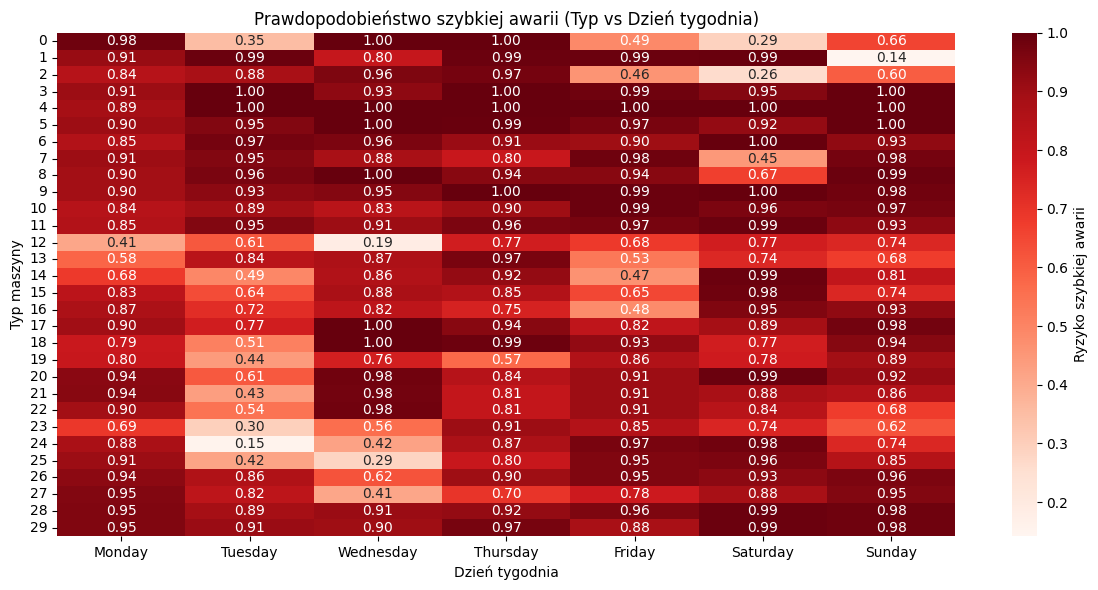

In [106]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Choose categories
types = df1["Typ_maszyny"].dropna().unique().tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"  # fixed value
poprzedni_odstep = 15  # fixed test value

# Create combinations
combinations = list(itertools.product(types, days))
test_df = pd.DataFrame(combinations, columns=["Typ_maszyny", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Poprzedni_odstep"] = poprzedni_odstep

# One-hot encode like training data
test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

# Predict
test_df["Prawdopodobieństwo_szybkiej_awarii"] = model.predict_proba(test_encoded)[:, 1]

# Pivot for heatmap
pivot = test_df.pivot_table(
    index="Typ_maszyny",
    columns="Dzien_tygodnia",
    values="Prawdopodobieństwo_szybkiej_awarii",
    aggfunc="mean"
)

# Optional: fix column order
pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title("Prawdopodobieństwo szybkiej awarii (Typ vs Dzień tygodnia)")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()
